## Data_Visualization_EIS.ipynb
#### Analyzes EIS Data from Big Kahuna for Convenient Feedback.
##### Miles Smith
##### 19 September 2023

In [1]:
import glob
import os
import math
import statistics
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
# Note that altair was downgraded to v3.0 for impedance.
from impedance.visualization import plot_nyquist, plot_residuals
from impedance.validation import linKK

###  Notes
10/2/2023 -- Data from vials 1, 4, 8, 13 came out potentially good at all T... only 12 of 45 samples came out adequate. 

Vial 1: 0.2 mol, 1.00 mol, 2.00 mol, 3.75 mol 



### Configure User Inputs

In [171]:
# Set the directory path to where the data files (*.txt) format are located on the computer
directory_path = '/Users/milessmith/Documents/GitHub/mit-tri-robot/data/19Sept2023' # Miles MacBook Pro
# directory_path = 'C:\\Users\miles\Documents\GitHub\mit-tri-robot\eis_sample_data'
# directory_path = 'C:\EIS' # Unchained Labs computer USE THIS DIRECTORY PATH IN 6-020

# Do you want to filter out bad data?
data_filter_selection = 1 # 1 = yes / 0 = no
# If yes, I use the expected value of the residuals compared to a model to determine if the data is adequate.
# What should the threshold be to flag data?
avg_residuals_cutoff = 0.05
# avg_residuals_cutoff = math.inf

# Cell Configuraton
diameter = 0.010 # [m] Electrode diameter
length = 0.0001 # [m] # Material thickness

# Select equivalent circuit model
user_circuit = 'R0-p(R2-Wo1,C2)'
# Initial guess of parameter values for ECM. From my observations this is a bit finnicky. 
user_guess = [10**4, 10**5, 10**5, 10**-1, 10**-10]

# Do you want multiple plots or each data array to be overlapped on each other?
overlay_data = 1  # 1 = yes | 0 = no

# Do you want to save the figures generated?
save_main_fig = 0 # 1 = yes | 0 = no

# What folder should the figure be saved to?
save_path = '/Users/milessmith/Documents/GitHub/mit-tri-robot/figures' # Miles MacBook Pro
# save_path = r'C:\\Users\miles\Documents\GitHub\mit-tri-robot\figures' # Miles' Windows computer
# save_path = r'C:\\Users\Unchained Labs\Documents\GitHub\mit-tri-robot\figures' # 6-020 computer



### Select Data files

In [172]:
'''
Example File structure: 103965_5_20230918_073125_25.txt
Plate Number: 103965
Vial Number (?): 5
Date: 20230918
Vial Code (?): 073125
Temperature (degC): 25
'''

### NOTICE: The underscores are an important aspect of the strings for temp and vial number. ###
# plate_number = '103965_'
plate_number = "skip"

vial_number = '_13_' # YOU CAN FILTER BY VIAL NUMBER
# vial_number = "skip"

# NOTE: Some of the dates are incorrect, so it might be good to configure the code to look at two dates. 
date1 = '_20230919_' # PICK THE DATE OF THE SAMPLE YOU ARE INTERESTED
# date1 = "skip"
date2 = '_20230918_'
# date2 = "skip"

# temperature = '_75' # YOU CAN FILTER BY TEMPERATURE
temperature = "skip"

### Frequency Range

The text (.txt) does not include the frequency, so I am manually importing this from a .mpt file. 
If we adjust the frequency range, then we will need to adjust this, but from my observations we always sample
using the same frequencies. This could be subject to change if we ever changed the scan rate, so it is
important to be mindful!

FYI: This specific frequency array probably only works as long as we are using a scan frequency of 0.2. 

In [173]:
# Note: Freq[Hz]
frequency = [ 6999984, 5969734, 5091109, 4341796, 3702781, 3157797, 2693047, 2296687, 1958656,1670375,
             1424531,1214875,1036062,883578.100000000,753531.200000000,642624.900000000,548046.800000000, 
             467390.600000000, 398593.700000000, 339937.500000000, 289906.200000000, 247234.400000000, 
             210843.700000000, 179812.500000000, 153343.800000000, 130781.200000000, 111531.300000000,  
             95109.3700000000, 81109.3700000000, 69171.8800000000, 59000, 50312.5000000000, 42906.2500000000, 
             36593.7500000000, 31203.1300000000, 26609.3800000000, 22703.1300000000, 19359.3700000000,  
             16500, 14112.0200000000, 12011.1300000000, 10236.3800000000, 8750.68400000000, 7449.46300000000, 
             6363.20600000000, 5414.76100000000, 4620.56700000000, 3941.21500000000, 3361.76900000000, 
             2867.24400000000, 2442.65800000000, 2083.00300000000, 1777.84300000000, 1513.54800000000, 
             1292.06500000000, 1101.76200000000, 939.101000000000, 801.280100000000, 684.343300000000, 
             582.947600000000, 497.067700000000, 423.508900000000, 361.503600000000, 308.126200000000, 
             262.729800000000, 224.211100000000, 191.285400000000, 163.172200000000, 139.153700000000, 
             118.670600000000, 101.198200000000, 86.2419600000000, 73.6102400000000, 62.6929100000000, 
             53.5769700000000, 45.6574600000000, 38.9651200000000, 33.1841400000000, 28.3061700000000, 
             24.1723700000000, 20.6134500000000, 17.5561800000000, 14.9855800000000, 12.7655300000000, 
             10.8809000000000, 9.27850500000000, 7.92339400000000, 6.75822000000000, 5.76142900000000, 
             4.91970800000000, 4.19125700000000, 3.56409700000000, 3.05175800000000, 2.60416400000000, 
             2.21442400000000, 1.89256700000000, 1.60750700000000, 1.37641300000000, 1.17375000000000, 
             1.00160400000000 ]

for i in range(len(frequency)):
    frequency[i] = np.int32(frequency[i])

f = np.array(frequency)

### Additional Functions

In [174]:
def ellipse(x, h, k, a, b):
    y = np.zeros(len(x))
    for i in range(len(x)):
        temp = np.sqrt(a**2 * (1 - ((x[i] - h) ** 2) / (a ** 2))) + k
        if temp >= 0:
            y[i] = temp
        else:
            y[i] = math.inf
    return y

### Downsize dataset to only the files of interest

In [175]:
### Read in all file names in EIS folder ###

# Specify the directory path and file extension pattern
extension_pattern = '*.txt'  # List .txt files, for example

# Get a list of file names matching the pattern in the directory
path_names = glob.glob(os.path.join(directory_path, extension_pattern))

# New list to append the files of interest
useful_path = []
for path in path_names:
    if (date1 in path) or (date1 == "skip") or (date2 in path) or (date2 == "skip"):
        if (vial_number in path) or (vial_number == "skip"):
            if (temperature in path) or (temperature == "skip"):
                if (plate_number in path) or (plate_number == "skip"):
                    useful_path.append(path)

print("Number of files selected: " + str(len(useful_path)))

Number of files selected: 6


### Data Import, Basic Analysis, and Figures
Here I imported the data from the system and did basic calculations for further analysis.


10 0.9997109048659308 13006.423520173614
[24, 39, 42, 44, 46, 85, 97]
h0 2: 485.3575754023942
Convergence Failed
Conductivity: 0.00131165104786874 S/m
['13', '75', 0.00131165104786874]
10 0.9997635551968052 31100.23866179369
[37, 51, 62, 97]
h0 2: 3079.026432891659


/var/folders/hx/mzdy_0px4vjdf00n9svk8mfw0000gn/T/ipykernel_65356/3650033572.py:4: RuntimeWarning: invalid value encountered in sqrt
  temp = np.sqrt(a**2 * (1 - ((x[i] - h) ** 2) / (a ** 2))) + k
/var/folders/hx/mzdy_0px4vjdf00n9svk8mfw0000gn/T/ipykernel_65356/2837575065.py:179: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  modelFig.show()
/var/folders/hx/mzdy_0px4vjdf00n9svk8mfw0000gn/T/ipykernel_65356/2837575065.py:185: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  residualFig.show()


Convergence Failed
Conductivity: 0.00020676008674914222 S/m
['13', '75', 0.00020676008674914222]
10 0.9993421839130652 77711.32487307458
[50, 56, 58, 62, 65, 70, 85, 97]
h0 2: 27915.32458244558
Convergence Failed
Conductivity: 2.280538671464765e-05 S/m
['13', '50', 2.280538671464765e-05]
10 0.999891418263388 34341.461996135986
[38, 52, 63, 85, 97]
h0 2: 3701.833331118862
Convergence Failed
Conductivity: 0.00017197418560580251 S/m
['13', '50', 0.00017197418560580251]
10 0.9999902474553344 101017.34104025195
[24, 27, 29, 36, 38, 40, 49, 60, 85, 97]
h0 2: 10.039128441759823
Convergence Failed
Conductivity: 0.06341384872808582 S/m
['13', '25', 0.06341384872808582]
10 0.9999913572030276 206954.60446001316
[22, 24, 26, 37, 43, 52, 72, 97]
h0 2: 11.034144933961871
Convergence Failed
Conductivity: 0.057695433237253985 S/m
['13', '25', 0.057695433237253985]
Number of Adequate Data Files:  6 | Number of Poor Data Files:  0 | Total Number of Files:  6


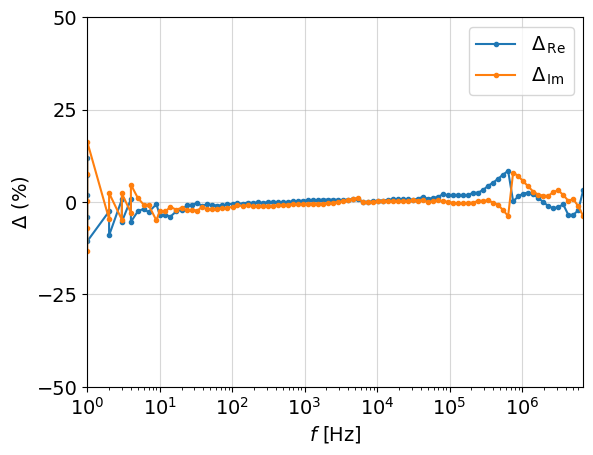

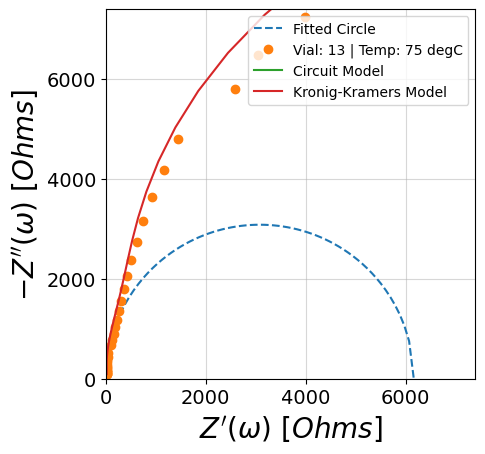

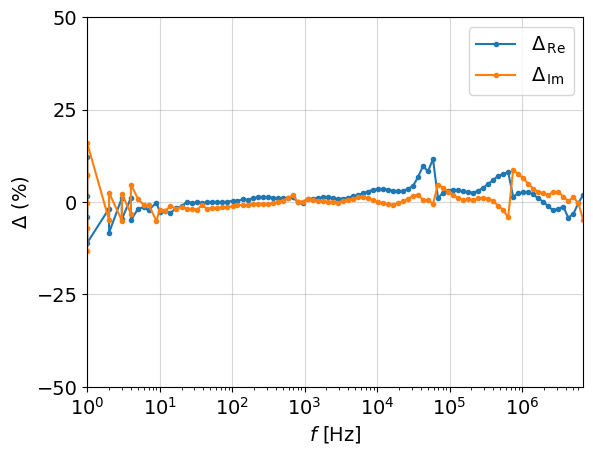

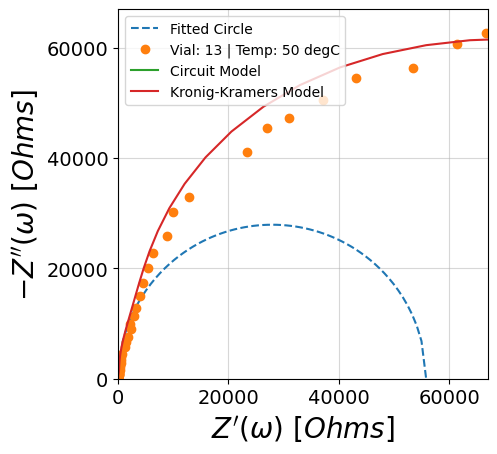

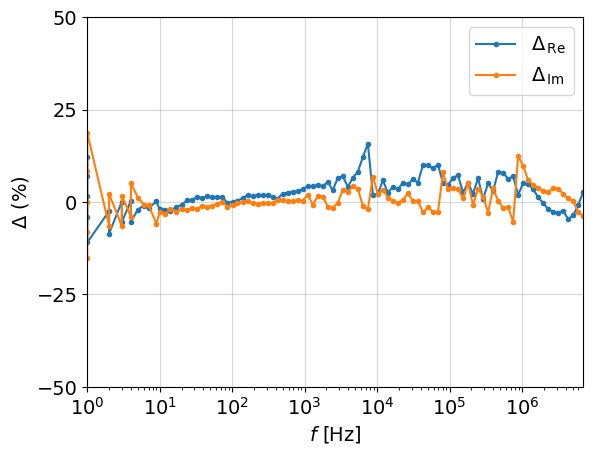

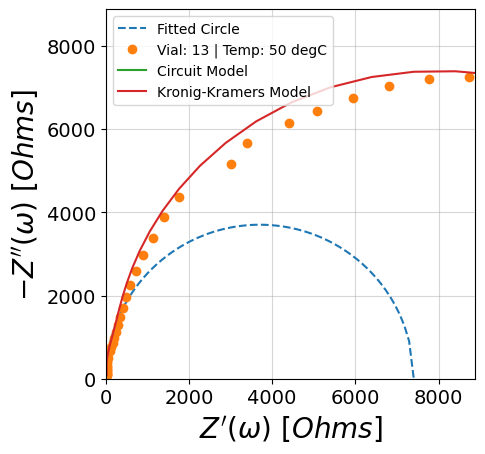

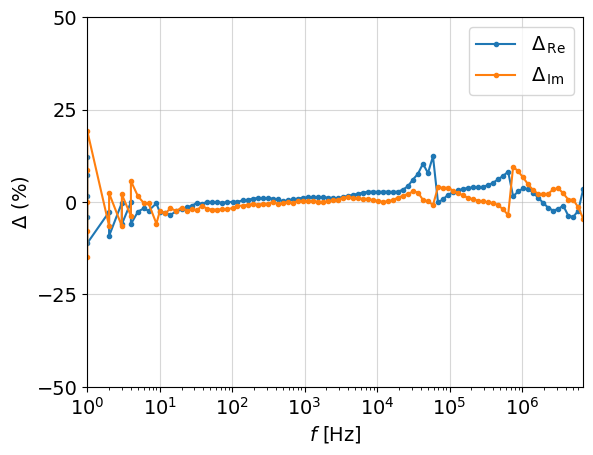

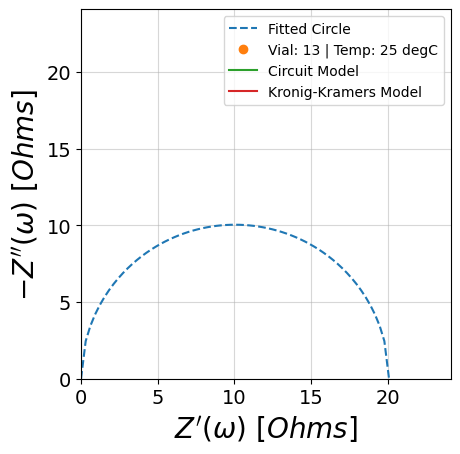

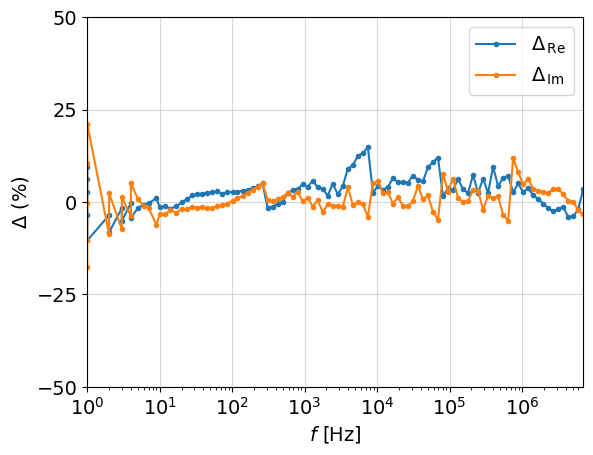

<Figure size 640x480 with 0 Axes>

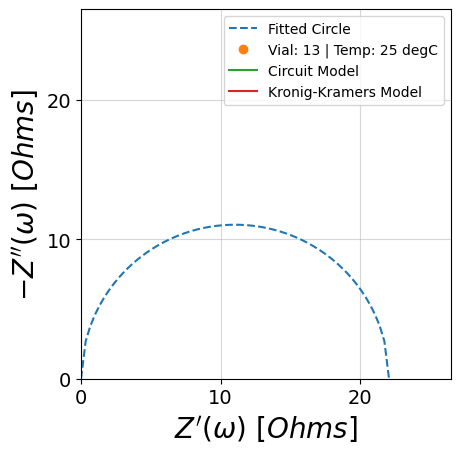

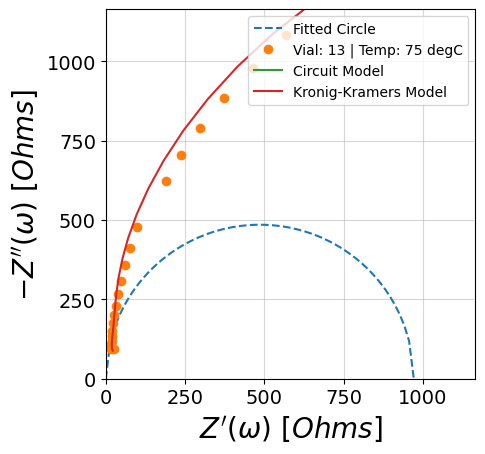

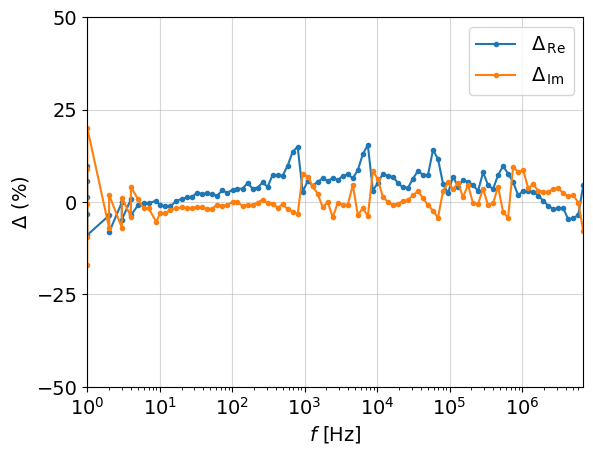

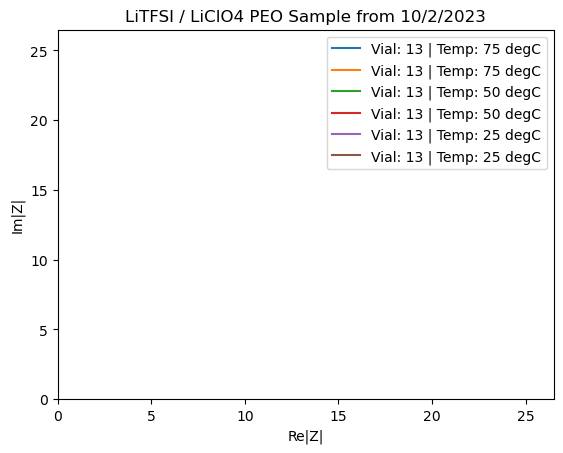

In [176]:
'''
Open and manage data from .txt files
'''
    
bad_data = 0
good_data = 0

for path in useful_path:
    
    # Open the file for reading
    with open(path, 'r') as file:
        
        # Extract sample information
        # Split the path into directory and filename
        directory, filename = os.path.split(path)
        # Extract the file name without the extension
        file_name_without_extension, file_extension = os.path.splitext(filename)
        path_info = file_name_without_extension.split('_')
        # Parse into useful variables
        plate_str = path_info[0]
        vial_str = path_info[1]
        date_str = path_info[2]
        vial_id_str = path_info[3]
        temp_str = path_info[4]
        
        '''
        conc_str = '0'
        if int(vial_str) == 1:
            conc_str = '0.2'
        elif int(vial_str) == 4:
            conc_str = '1'
        elif int(vial_str) == 8:
            conc_str = '2'
        elif int(vial_str) == 13:
            conc_str = '3.75'
        '''
        
        path_id = "Vial: " + vial_str + " | Temp: " + temp_str + " degC"
        # conc_id = conc_str + " mol  at " + temp_str + "degC"
        
        # Initialize arrays for impedance and conductivity values.
        ReZOhm = []
        ImZOhm = []
        conductivity = []
        i = 0

        area = math.pi*diameter**2/4
                
        # Parse each line in the .txt files to the correct array.
        for line in file:
            ZOhm_Values = line.split()
            ReZOhm.append(float(ZOhm_Values[0]))
            ImZOhm.append(float(ZOhm_Values[1]))
            i += 1
            
        ZOhm = []
        ZVector = []
        ZPhase = []
        
        for i in range(len(ReZOhm)):
            Z_temp = ReZOhm[i] - 1j*ImZOhm[i] # Rearrange into format of array. 
            ZOhm.append(Z_temp)
            ZVector.append(math.sqrt(ReZOhm[i]**2+ImZOhm[i]**2))
            ZPhase.append(math.atan(ImZOhm[i]/ReZOhm[i])*180/math.pi) # Phase in degrees = atan(Im|Z|/Re|Z|)
            
        Z = np.array(ZOhm)
                
        f_KK = f
        Z_KK = Z
        
        # Create a linear Kronig-Kramers model to fit data
        try:
            M, mu, Z_linKK, res_real, res_imag = linKK(f_KK, Z_KK, c=.85, max_M=100, fit_type='complex', add_cap=True)
            Re_residuals_avg = statistics.mean(abs(res_real))
            Im_residuals_avg = statistics.mean(abs(res_imag))
            if (data_filter_selection == 1):
                bad_data_threshold = avg_residuals_cutoff
            else:
                bad_data_threshold = math.inf
        except:
            print("[XX] Data type and structure error in: ", file.name)
            bad_data += 1
            continue
            
        # Use linKK to identify which datasets have large residuals. 
        if Re_residuals_avg < bad_data_threshold or Im_residuals_avg < bad_data_threshold:
            # print("[!!] Residuals are good in: ", file.name)
            good_data += 1
            Z = ZOhm

        else:
            # print("[XX] High residuals in: ", file.name)
            bad_data += 1
            continue
        
        if len(Z) == len(f):
            dZ = np.zeros(len(res_imag))
            critical_points = []
            prev_median = 1
            for i in range(len(res_imag)):
                if i > 0:
                    dZ[i] = -(res_imag[i]-res_imag[i-1])
                    buff_size = 10
                    if i > buff_size:
                        temp_buf = []
                        for j in range(buff_size):
                            temp_buf.append(dZ[i-j])
                        temp_median = statistics.median(temp_buf)
                        if (temp_median > 0) and (prev_median < 0):
                            critical_points.append(i)
                        prev_median = temp_median
            
            print(critical_points)
            erroneous_critical_point_index = 40
            if critical_points[0] > erroneous_critical_point_index:
                    Z_circle = Z_linKK[1:critical_points[0]]
            else:
                Z_circle = Z_linKK[1:critical_points[1]-15]
        
        # Fit to an ellipse.. How shall we generalize?
        h0 = max(Z_circle.real)/2 # Center position x
        print("h0 2: " + str(h0))
        k0 = 0
        a0 = max(Z_circle.real)/2 # x radius
        b0 = max(Z_circle.real)/2 # y radius

        p0 = (h0, k0, a0, b0)  # Initial guesses for parameters

        try:
            optimized_params, _ = curve_fit(ellipse, Z_circle.real, -Z_circle.imag, p0=p0, method='dogbox')
            Re_Z_range = np.linspace(0, max(Z_circle.real)*1.5, 100)
            Im_Z_fit = ellipse(Re_Z_range, *optimized_params)
            # print("[!!] Vial: " + vial_str + " Temp: " + temp_str + " | Parameters converged")
            # conductivity_val = (1/Z_high[0])*length/area
            conductivity_val = (1/(2*optimized_params[2]))*length/area
            print("Conductivity: " + str(conductivity_val) + " S/m")
            conductivity_array = [vial_str, temp_str, conductivity_val]
            print(conductivity_array)
        except:
            print("Convergence Failed")
            Re_Z_range = np.linspace(0, max(Z_circle.real)*1.5, 100)
            Im_Z_fit = ellipse(Re_Z_range, *p0)
            conductivity_val = (1/(2*p0[2]))*length/area
            print("Conductivity: " + str(conductivity_val) + " S/m")
            conductivity_array = [vial_str, temp_str, conductivity_val]
            print(conductivity_array)
            
        figure_lim = max(Z_circle.real)*1.2

        Z_poly = []
        for i in range(len(Re_Z_range)):
            Z_temp = Re_Z_range[i] - 1j*Im_Z_fit[i]
            Z_poly.append(Z_temp)

        Z_low = Z_poly[0].real
        Z_high = Re_Z_range[np.where(Im_Z_fit == min(Im_Z_fit))]

        if (save_main_fig == 1):
            pass
        else:
            circuit = user_circuit
            # Initial guess of parameter values for ECM. From my observations this is a bit finnicky. 
            initial_guess = user_guess
            circuit = CustomCircuit(circuit, initial_guess=initial_guess)
            # Fit data to equivalent circuit model
            circuit.fit(f, Z)
            Z_fit = circuit.predict(f)

            # Create Nyquist Plot
            plt.figure(4)
            modelFig, ax = plt.subplots()
            plot_nyquist(Z_poly, fmt = '--', scale = 1, ax = ax)
            plot_nyquist(Z, fmt='o', scale=1, ax=ax)
            plot_nyquist(Z_fit, fmt='-', scale=1, ax=ax)
            plot_nyquist(Z_linKK, fmt='-', scale=1, ax=ax)
            plt.legend(['Fitted Circle', path_id, 'Circuit Model', 'Kronig-Kramers Model', 'circle'])
            plt.xlim((0, figure_lim))
            plt.ylim((0, figure_lim))
            modelFig.show()

            # Plot residuals
            plt.figure(5)
            residualFig, ax2 = plt.subplots()
            plot_residuals(ax2, f_KK, res_real, res_imag, y_limits=(-50, 50))
            residualFig.show()

        '''
        Make figures 
        '''
        '''
        plt.figure(1)
        plt.plot(frequency, conductivity, label = path)
        plt.title('Conductivity as a function of frequency')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Conductivity [S/m]')
        plt.legend(bbox_to_anchor=(1, 1))
        # plt.ylim((0, 10))
        '''

        plt.figure(2)
        #plt.loglog(ReZOhm, ImZOhm, label = path) # I know this is unconventional, but it makes it easier to look at multiple lines.
        plt.plot(ReZOhm, ImZOhm, label = path_id)
        # plt.plot(np.real(Z_linKK), -np.imag(Z_linKK), linestyle = '--', label = path)
        plt.title('LiTFSI / LiClO4 PEO Sample from 10/2/2023')
        plt.xlabel('Re|Z|')
        plt.ylabel('Im|Z|')
        plt.legend()
        plt.xlim((0, figure_lim))
        plt.ylim((0, figure_lim))

        '''
        plt.figure(3)
        fig, ax1 = plt.subplots()
        plt.title('Bode Plot: Magnitude and Phase as a function of Frequency')
        color = 'tab:blue'
        ax1.set_xlabel('Frequency [Hz]')
        ax1.set_ylabel('Magnitude', color=color)
        ax1.loglog(frequency, ZVector, label = path)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Phase', color=color)  # we already handled the x-label with ax1
        ax2.loglog(frequency, ZPhase, color = color)
        ax2.tick_params(axis='y', labelcolor=color)
        '''

print("Number of Adequate Data Files: ", good_data, "| Number of Poor Data Files: ", bad_data, "| Total Number of Files: ", good_data+bad_data)

if (save_main_fig == 1):
    # plt.savefig(save_path+'\mainfigure.png') # if Windows
    plt.savefig(save_path+'/mainfigure.png') # if Mac

